In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# import mnist dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Parameters
learning_rate = 0.001
examples_to_show = 10

# Small epsilon value for the BN transform
epsilon = 1e-3

In [3]:
# Store weights and biases

w1_initial = np.random.normal(size=(3, 3, 1, 32)).astype(np.float32)
w2_initial = np.random.normal(size=(3, 3, 32, 64)).astype(np.float32)
w3_initial = np.random.normal(size=(7*7*64, 1024)).astype(np.float32)
w4_initial = np.random.normal(size=(1024, 256)).astype(np.float32)
w5_initial = np.random.normal(size=(256, 1024)).astype(np.float32)
w6_initial = np.random.normal(size=(1024, 7*7*64)).astype(np.float32)
w7_initial = np.random.normal(size=(3, 3, 32, 64)).astype(np.float32)
w8_initial = np.random.normal(size=(3, 3, 1, 32)).astype(np.float32)

b1_initial = np.random.normal(size=(32)).astype(np.float32)
b2_initial = np.random.normal(size=(64)).astype(np.float32)
b3_initial = np.random.normal(size=(1024)).astype(np.float32)
b4_initial = np.random.normal(size=(256)).astype(np.float32)
b5_initial = np.random.normal(size=(1024)).astype(np.float32)
b6_initial = np.random.normal(size=(7*7*64)).astype(np.float32)
b7_initial = np.random.normal(size=(32)).astype(np.float32)
b8_initial = np.random.normal(size=(1)).astype(np.float32)

In [4]:
def activation(_input, activation='relu'):
    if activation == 'relu':
        return tf.nn.relu(_input)
    elif activation == 'sigmoid':
        return tf.nn.sigmoid(_input)

In [5]:
def batch_norm_wrapper(inputs, is_training, decay=0.999):
    channels = inputs.get_shape().as_list()[-1]
    offset = tf.get_variable('bn_offset', 
                             [channels], dtype=tf.float32,
                             initializer=tf.zeros_initializer())
    scale = tf.get_variable('bn_scale', 
                            [channels], 
                            dtype=tf.float32, 
                            initializer=tf.random_normal_initializer(1.0, 0.02))
    pop_mean = tf.Variable(tf.zeros([channels]), trainable=False)
    pop_var = tf.Variable(tf.ones([channels]), trainable=False)
    
    if is_training:
        batch_mean, batch_var = tf.nn.moments(inputs,[0,1,2], keep_dims=False)
        train_mean = tf.assign(pop_mean,
                               pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var,
                              pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs, batch_mean, batch_var, offset, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs, pop_mean, pop_var, offset, scale, epsilon)

In [6]:
# create model

def build_graph(is_training):
    
    # tf input graph
    X = tf.placeholder(tf.float32, [None, 784])
    batch_size = tf.shape(X)[0]
    
    reshaped_x = tf.reshape(X, (-1, 28, 28, 1))
    print(reshaped_x.shape)

    # Convolutional layer 1
    with tf.variable_scope('conv_1'):
        wec1 = tf.Variable(w1_initial)
        bec1 = tf.Variable(b1_initial)
        conv1 = tf.add(tf.nn.conv2d(reshaped_x, wec1, strides=[1, 2, 2, 1], padding='SAME'), bec1)
        bn1 = batch_norm_wrapper(conv1, is_training=is_training)
        conv1 = activation(bn1)
        #print(conv1.shape)

    with tf.variable_scope('conv_2'):
        wec2 = tf.Variable(w2_initial)
        bec2 = tf.Variable(b2_initial)
        conv2 = tf.add(tf.nn.conv2d(conv1, wec2, strides=[1, 2, 2, 1], padding='SAME'), bec2)
        bn2 = batch_norm_wrapper(conv2, is_training=is_training)
        conv2 = activation(bn2)
        #print(conv2.shape)

    with tf.variable_scope('fc_1'):
        wef1 = tf.Variable(w3_initial)
        bef1 = tf.Variable(b3_initial)
        fce1 = tf.reshape(conv2, (-1, 7*7*64))
        fce1 = activation(tf.add(tf.matmul(fce1, wef1), bef1))
        #print(fce1.shape)

    with tf.variable_scope('fc_2'):
        wef2 = tf.Variable(w4_initial)
        bef2 = tf.Variable(b4_initial)
        encode = activation(tf.add(tf.matmul(fce1, wef2), bef2))
        #print(encode.shape)
        
    with tf.variable_scope('fc_3'):
        wdf1 = tf.Variable(w5_initial)
        bdf1 = tf.Variable(b5_initial)
        fcd1 = activation(tf.add(tf.matmul(encode, wdf1), bdf1))
        #print(fcd1.shape)

    with tf.variable_scope('fc_4'):
        wdf2 = tf.Variable(w6_initial)
        bdf2 = tf.Variable(b6_initial)
        fcd2 = activation(tf.add(tf.matmul(fcd1, wdf2), bdf2))
        fcd2 = tf.reshape(fcd2, (-1, 7, 7, 64))
        #print(fcd2.shape)

    with tf.variable_scope('deconv_1'):
        wdd1 = tf.Variable(w7_initial)
        bdd1 = tf.Variable(b7_initial)
        deconv1 = tf.nn.conv2d_transpose(fcd2, 
                                         wdd1, 
                                         output_shape=tf.stack([batch_size, 14, 14, 32]), 
                                         strides=[1, 2, 2, 1],
                                         padding='SAME')
        deconv1 = tf.add(deconv1, bdd1)
        deconv1 = tf.reshape(deconv1, (batch_size, 14, 14, 32))
        bn3 = batch_norm_wrapper(deconv1, is_training=is_training)
        deconv1 = activation(bn3)
        #print(deconv1.shape)

    with tf.variable_scope('deconv_2'):
        wdd2 = tf.Variable(w8_initial)
        bdd2 = tf.Variable(b8_initial)
        deconv2 = tf.nn.conv2d_transpose(deconv1,
                                         wdd2,
                                         output_shape=tf.stack([batch_size, 28, 28, 1]),
                                         strides=[1, 2, 2, 1],
                                         padding='SAME')
        deconv2 = tf.add(deconv2, bdd2)
        deconv2 = tf.reshape(deconv2, (batch_size, 28, 28, 1))
        bn4 = batch_norm_wrapper(deconv2, is_training=is_training)
        deconv2 = activation(bn4)
        #print(deconv2.shape)

    decode = tf.reshape(deconv2, (-1, 784))

    cost = tf.reduce_mean(tf.square(decode - X))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


    return X, encode, decode, cost, optimizer, tf.train.Saver()

In [7]:
#Build training graph, train and save the trained model
tf.reset_default_graph()
X, _, _, cost, optimizer, saver = build_graph(is_training=True)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(5000):
        batch = mnist.train.next_batch(60)
        optimizer.run(feed_dict={X: batch[0]})
        if i % 100 is 0:
            c = sess.run([cost],feed_dict={X: batch[0]})
            print('Iter:{0}, Minibatch-cost:{1}'.format(i, c[0]))
    saved_model = saver.save(sess, './save_cae/temp-bn-save')

print("Optimization Done!")

(?, 28, 28, 1)
(?, 14, 14, 32)
(?, 7, 7, 64)
(?, 1024)
(?, 256)
(?, 1024)
(?, 7, 7, 64)
(?, 14, 14, 32)
(?, 28, 28, 1)
Iter:0, Minibatch-cost:0.460896015167
Iter:100, Minibatch-cost:0.0708047151566
Iter:200, Minibatch-cost:0.0600918531418
Iter:300, Minibatch-cost:0.0511237643659
Iter:400, Minibatch-cost:0.0431177765131
Iter:500, Minibatch-cost:0.03758790344
Iter:600, Minibatch-cost:0.0296867117286
Iter:700, Minibatch-cost:0.0251566655934
Iter:800, Minibatch-cost:0.0250085238367
Iter:900, Minibatch-cost:0.0210404712707
Iter:1000, Minibatch-cost:0.0194837357849
Iter:1100, Minibatch-cost:0.0163002479821
Iter:1200, Minibatch-cost:0.0148286977783
Iter:1300, Minibatch-cost:0.014999166131
Iter:1400, Minibatch-cost:0.0148470457643
Iter:1500, Minibatch-cost:0.0128916036338
Iter:1600, Minibatch-cost:0.0139916399494
Iter:1700, Minibatch-cost:0.0111674442887
Iter:1800, Minibatch-cost:0.0120390700176
Iter:1900, Minibatch-cost:0.0116423396394
Iter:2000, Minibatch-cost:0.0107246823609
Iter:2100, Mini

(?, 28, 28, 1)
(?, 14, 14, 32)
(?, 7, 7, 64)
(?, 1024)
(?, 256)
(?, 1024)
(?, 7, 7, 64)
(?, 14, 14, 32)
(?, 28, 28, 1)
INFO:tensorflow:Restoring parameters from ./save_cae/temp-bn-save


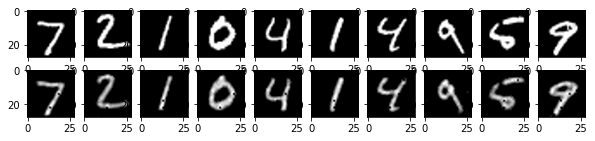

In [12]:
tf.reset_default_graph()
X, _, decode, _, _, saver = build_graph(is_training=False)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './save_cae/temp-bn-save')
    
    recons_out = sess.run(decode, feed_dict={X: mnist.test.images[:examples_to_show]})
    
# compare the original images with the reconstructions
f, a = plt.subplots(2, 10, figsize=(10,2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28,28)), cmap='gray', interpolation='spline16')
    a[1][i].imshow(np.reshape(recons_out[i], (28,28)), cmap='gray', interpolation='spline16')
plt.draw()
plt.show()